# Graph-to-Point Cloud Spin Lifting Tutorial

***
The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired transformation, create a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) tests that the lifting creates the expected point cloud.
- [Create and run a nn model over the point cloud](#create-and-run-a-nn-model-over-the-point-cloud) simply runs a forward pass of the model to check that everything is working as expected.

***

## Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool import knn_graph
from torch_geometric.nn.pool.glob import global_max_pool

from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_transform_config,
)

## Loading the Dataset

In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


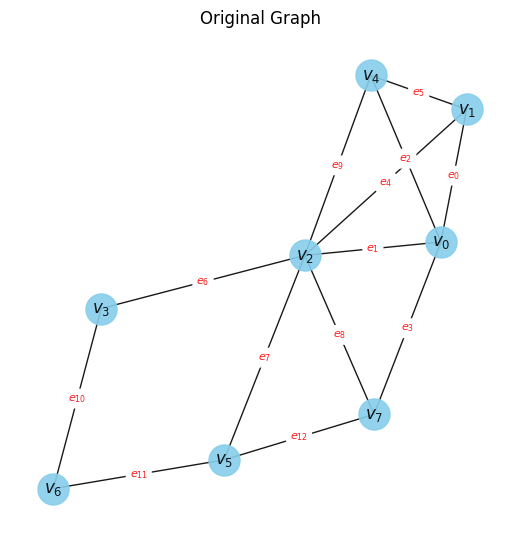

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. We are going to implement SpinLifting from the graph domain to the point cloud domain. This lifting method is based on the circular layout of graph drawing methods. Circular layout[[1]](https://en.wikipedia.org/wiki/Circular_layout) is a method where all nodes are placed around the perimeter of a circle. Typical problems with this layout are that the nodes are too densely packed and the connectivity between the nodes is not reflected in the relative positions of the nodes. 

***
[[1]](https://en.wikipedia.org/wiki/Circular_layout) Circular layout - Wikipedia
***

Our SpinLifting method improves on this: in breadth-first visit manner, a central point is first identified, then the neighbours of that point are placed on a circle around the point in counterclockwise order, and for each neighbouring point that has been placed, the neighbours of that point are then placed in the same way, on a circle around that point. This process is repeated until all points have been placed in the coordinate system. If a point has already been assigned coordinates, but the algorithm encounters it again, this point will be skipped (no adjustment is made to the assigned coordinates).

The algorithm starts by assigning coordinates around a point with a rotation angle of 30°, if there are too many neighbours resulting in not enough space, the rotation angle is halved to 15°, if there are more neighbours resulting in again not enough space it is halved again to 7.5°, and so on. If the algorithm encounters a graph with multiple disconnected parts, each part will be separated by a distance of $max$(max distance between nodes in each of the current parts) to ensure that the parts are far enough apart.

In [4]:
# Define transformation type and id
transform_type = "liftings"

transform_id = "graph2pointcloud/spin_lifting"

# Read yaml file
transform_config = {"lifting": load_transform_config(transform_type, transform_id)}


Transform configuration for graph2pointcloud/spin_lifting:

{'transform_type': 'lifting', 'transform_name': 'SpinLifting', 'start_node': 0}


We then apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /Users/bpefei/Documents/MResWorks/MResProject/Projects/New-Challenge/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/3866166149


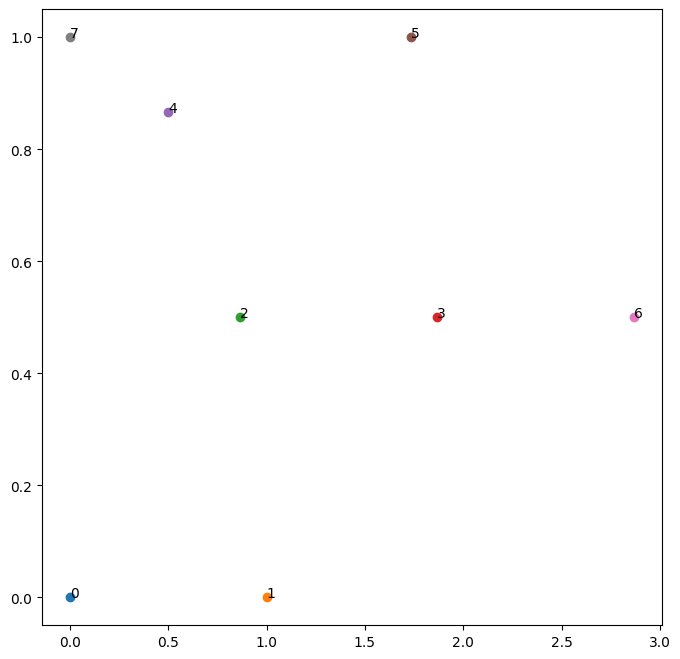

In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
# Draw the points with labels

for n, (x, y) in enumerate(lifted_dataset.pos):
    (x, y) = (x.item(), y.item())
    plt.scatter(x, y)
    plt.text(x, y, str(n))
plt.show()

## Create and Run a nn model over the point cloud

In this section a simple model is created to test that the used lifting works as intended.

In [6]:
# Use KNNGraph to create a graph from the point cloud
generated_edge_index = knn_graph(lifted_dataset.pos, k=2, loop=False)
lifted_dataset.edge_index = generated_edge_index

In [7]:
# Use PointNet as a simple model
class PointNetLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        # Message passing with "max" aggregation.
        super().__init__(aggr="max")

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden
        # node dimensionality plus point dimensionality (=2).
        self.mlp = Sequential(
            Linear(in_channels + 2, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(
        self,
        h: torch.Tensor,
        pos: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(
        self,
        h_j: torch.Tensor,
        pos_j: torch.Tensor,
        pos_i: torch.Tensor,
    ) -> torch.Tensor:
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, 2]
        # pos_i: The central node position as shape [num_edges, 2]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)

In [8]:
class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = PointNetLayer(2, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(
        self,
        pos: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        # Perform two-layers of message passing:
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # Global Pooling:
        h = global_max_pool(h, batch=None)  # [num_examples, hidden_channels]

        # Classifier:
        return self.classifier(h)


model = PointNet()

If everything is correct the cell above should execute without errors.

In [9]:
model(lifted_dataset.pos, lifted_dataset.edge_index)

tensor([[ 0.0204, -0.1859]], grad_fn=<AddmmBackward0>)